# 
We hypothesize that stimulus-evoked changes in the LFP aperiodic offset reflect increased spiking activity in the underlying population. This notebook will investigate this hypothesis by computing stimulus-evoked changes in multi-unit spiking activity (MUA), and integrating these results with our previous spectral parameter results.  

# Analyze and plot MUA activity with LFP offset and exponent

created: --- <br>
last modified:  July 24, 2024

### Imports

In [1]:
# general
import numpy as np
import matplotlib.pyplot as plt
from neurodsp.utils import create_times
import pandas as pd
from scipy.stats import linregress
from scipy.signal import decimate

# custom
import sys
sys.path.append("../code")
from utils import load_nix, epoch_neo_segment, epoch_nix
from plots import plot_schematic
from paths import PROJECT_PATH, EXTERNAL_PATH
from info import SESSIONS, N_ARRAYS, N_CHANS, EPOCH_TIMES

# settings
plt.style.use('../mpl_styles/default.mplstyle')

#### Settings

In [2]:
# Session of interest (will ultimately apply to all sessions)
SESSION = SESSIONS[2]
SESSION

'L_SNR_250717'

In [3]:
# Dataset details
DURATION = 0.3 # duration of pre-/post-stimulus epoch (s)
T_MIN = -0.3 # minimum time (s)

## Main

#### Create output directory

In [3]:
# make figure output directory
import os
DIR_FIG = f"{PROJECT_PATH}/figures/mua_v_params"
if not os.path.exists(DIR_FIG):
    os.makedirs(DIR_FIG)

In [4]:
dir_out = f"{PROJECT_PATH}/figures/"
if not os.path.exists(dir_out):
    os.makedirs(dir_out)

#### load data

In [6]:
# # load LFP spectral parameter results (pre-stm)
# results = pd.read_csv(fr"{PROJECT_PATH}\data\results\lfp_spectral_params.csv", index_col=0)
# results

In [5]:
# load STM LFP data
lfp_data = pd.read_csv(fr"{PROJECT_PATH}\data\results\lfp_stm_params.csv")
lfp_data

,Unnamed: 0,session,channel,chan_idx,array,event,window,offset,knee,exponent,...,alpha_pw,alpha_bw,beta_cf,beta_pw,beta_bw,gamma_cf,gamma_pw,gamma_bw,error,r_squared
0,0,A_SNR_041018,0,0,1,0,0,6.795210,-1.846419,2.337249,...,NaN,NaN,20.890956,0.224983,11.992839,84.198499,0.132514,12.000000,0.032021,0.997366
1,1,A_SNR_041018,0,0,1,0,1,6.737711,-4.511377,2.295678,...,NaN,NaN,20.902825,0.226633,12.000000,61.621175,0.182840,3.827135,0.039661,0.995919
2,2,A_SNR_041018,0,0,1,0,2,6.755493,-4.149983,2.305570,...,NaN,NaN,20.926484,0.222615,12.000000,61.539609,0.193738,3.815145,0.041530,0.995477
3,3,A_SNR_041018,0,0,1,0,3,6.780586,-3.431958,2.320047,...,NaN,NaN,20.866057,0.221432,11.833854,61.507654,0.193887,3.920132,0.040069,0.995806
4,4,A_SNR_041018,0,0,1,0,4,6.825531,-1.580806,2.347456,...,NaN,NaN,20.796904,0.222093,11.686082,61.560461,0.184212,4.285739,0.035822,0.996423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535995,511995,L_SNR_250717,63,1023,16,1023,495,6.992720,-1.496442,2.293409,...,NaN,NaN,20.553714,0.316953,8.651914,62.071582,0.364958,7.753122,0.095770,0.975272
1535996,511996,L_SNR_250717,63,1023,16,1023,496,6.971888,-1.889051,2.283320,...,NaN,NaN,20.532249,0.318419,8.686486,61.977642,0.361673,7.517469,0.094312,0.975615
1535997,511997,L_SNR_250717,63,1023,16,1023,497,6.994990,-0.191089,2.298115,...,NaN,NaN,20.600150,0.298774,8.555499,62.022368,0.360953,7.569785,0.094283,0.975664
1535998,511998,L_SNR_250717,63,1023,16,1023,498,6.949316,-1.983348,2.277146,...,NaN,NaN,20.508147,0.316415,8.653674,61.919241,0.364432,7.401750,0.093088,0.976546


#### demo importing and plotting MUA data

In [49]:
# fname_in = r"D:\V1_v4_1024_electrode_resting_state_data\data\A_SNR_041018\LFP\NSP1_array1_LFP.nix"
# segment, analog_signal = load_nix(fname_in)
# segment

Segment with 1 analogsignals, 1 epochs
annotations: {'nix_name': 'neo.segment.6ba8a531c26c41339f7d5190ef8e464d'}
# analogsignals (N=1)
0: AnalogSignal with 64 channels of length 78644; units uV; datatype float64 
   annotations: {'nix_name': 'neo.analogsignal.156915c6aa0a4e94b1b998cd3854ca10',
     't_stop': array(157.288) * s}
   sampling rate: 500.0 Hz
   time: 0.0 s to 157.288 s

In [37]:
# fname_in = r"D:\V1_v4_1024_electrode_resting_state_data\data\A_SNR_041018\MUAe\NSP1_array1_MUAe.nix"
# segment, analog_signal = load_nix(fname_in)
# segment

Segment with 1 analogsignals, 1 epochs
annotations: {'nix_name': 'neo.segment.b0f01ad16cc84dbda66784bf87107104'}
# analogsignals (N=1)
0: AnalogSignal with 64 channels of length 157288; units uV; datatype float64 
   annotations: {'nix_name': 'neo.analogsignal.85ba2b95acfb4c0491f18a9f7529ecbf',
     't_stop': array(157.288) * s}
   sampling rate: 1000.0 Hz
   time: 0.0 s to 157.288 s

Sampling rate: 1000.0 Hz
Signal duration: 0.064 s
N channels: 64
N trials: 102


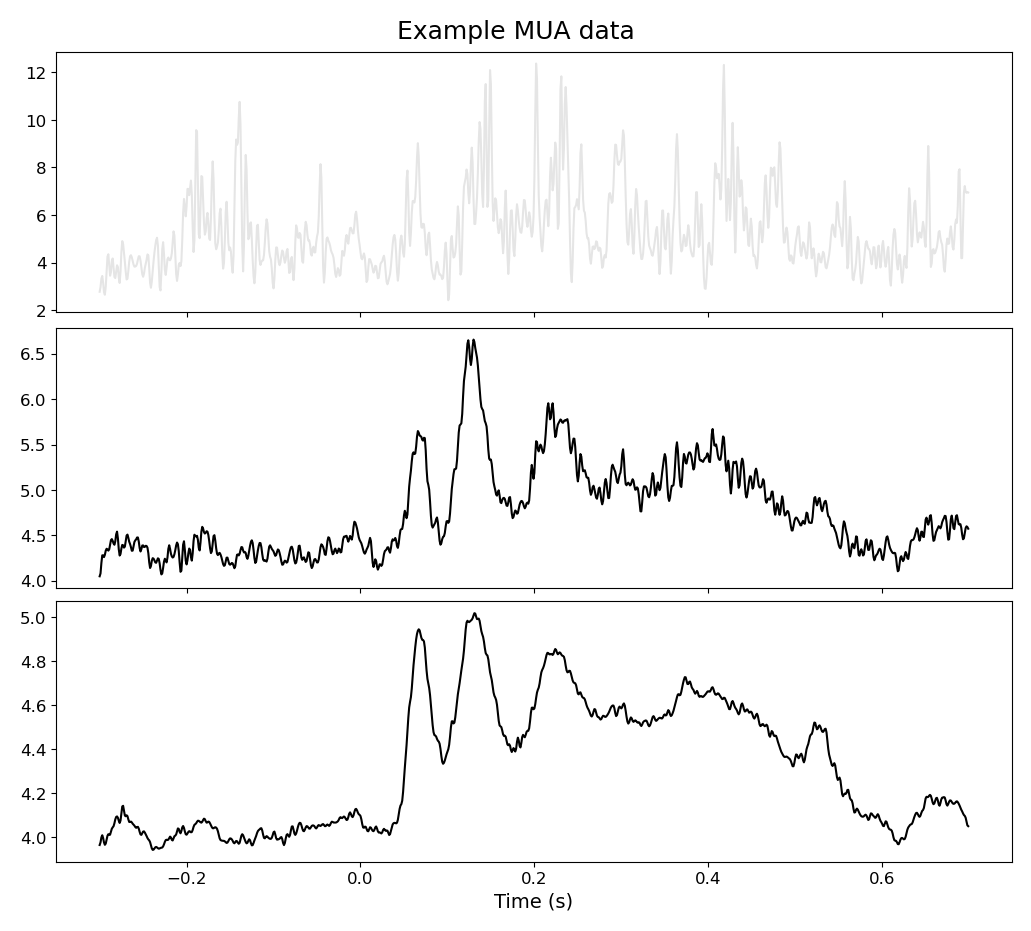

In [76]:
# # load example MUA data
# fname_in = r"D:\V1_v4_1024_electrode_resting_state_data\data\A_SNR_041018\MUAe\NSP1_array1_MUAe.nix"
# segment, analog_signal = load_nix(fname_in)
# signal = segment.analogsignals[0].T # transpose to get channels x time
# fs = analog_signal._sampling_rate.item()

# # epoch data into trials around stimulus times
# epochs = epoch_neo_segment(segment, segment.epochs[0], reset_time=True) 
# epoch_times = create_times(epochs.shape[-1]/fs, fs, start_val=EPOCH_TIMES[0]) # get times for each epoch

# # print info
# print(f"Sampling rate: {fs} Hz")
# print(f"Signal duration: {signal.duration.item()} s")
# print(f"N channels: {signal.shape[0]}")
# print(f"N trials: {len(segment.epochs[0])}")

# # plot example trial, example channel, and grand average
# fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=[10,9], sharex=True)
# fig.suptitle(f"Example MUA data")
# ax1.plot(epoch_times, epochs[0,0,:].T, color="k", alpha=0.1) # plot first trial
# ax2.plot(epoch_times, epochs[:,0,:].mean(axis=0), color="k") # plot first channel (mean across trials)
# ax3.plot(epoch_times, epochs.mean(axis=(0,1)), color="k") # plot mean across all trials and channels
# ax3.set_xlabel("Time (s)")
# plt.show()

In [91]:
# # downsample MUAe signal from 1000Hz to LFP sampling rate (500Hz)
# # on NSP 1 channel 1 average across 102 trials
# chan_1 = epochs[:,0,:].mean(axis=0) # first channel, mean across trials 
# mua_times = decimate(chan_1, 2) # downsample

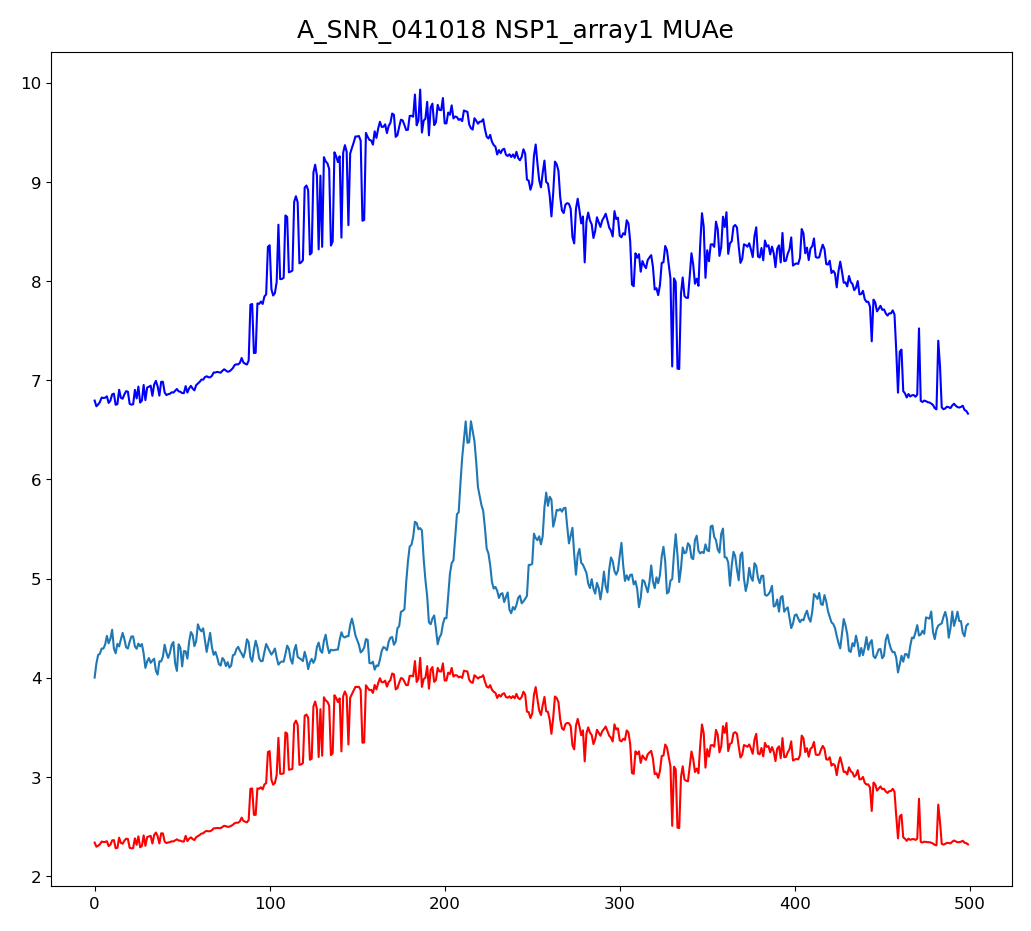

In [90]:
# # plot mua with offset and exponent
# lfp1_off = np.array(lfp_data.iloc[range(500)].get('offset'))
# lfp1_exp = np.array(lfp_data.iloc[range(500)].get('exponent'))

# fig, ax = plt.subplots(figsize=[10,9])
# fig.suptitle(f"A_SNR_041018 NSP1_array1 MUAe")
# ax.plot(mua_times) # plot first trial
# ax.plot(lfp1_off, c='b')
# ax.plot(lfp1_exp, c='r')

### Compute time-locked MUA for each session

In [8]:
mua_data = np.array([])

for session in SESSIONS:
    print(f"session : {session}")

    # loop through arrays
    for i_array in range(1, N_ARRAYS+1):
        ### print(f"    plotting array: {i_array}/{N_ARRAYS}")
        idx_nsp = (i_array+1) // 2

        # load data
        fname_in = fr"{EXTERNAL_PATH}\V1_v4_1024_electrode_resting_state_data\data\{session}\MUAe\NSP{idx_nsp}_array{i_array}_MUAe.nix"
        segment, analog_signal = load_nix(fname_in)
        signal = segment.analogsignals[0].T # transpose to get channels x time
        fs = analog_signal._sampling_rate.item()

        # epoch data into trials around stimulus times
        epochs = epoch_neo_segment(segment, segment.epochs[0], reset_time=True) 
        epoch_times = create_times(epochs.shape[-1]/fs, fs, start_val=EPOCH_TIMES[0]) # get times for each epoch

        for i_chan in range(N_CHANS):
            # downsample MUAe signal from 1000Hz to LFP sampling rate (500Hz)
            chan_mua = epochs[:,i_chan,:].mean(axis=0) # mean across trials 
            mua_times = decimate(chan_mua, 2) 
            
            mua = np.append(mua, mua_times)
        
    idx_nsp = 0

data = lfp_data.assign(mua=mua)
data.to_csv(f'{PROJECT_PATH}/data/results/lfp_stm_params_mua.csv')

session : A_SNR_041018
session : A_SNR_140819
session : L_SNR_250717


#### Compute average MUA for the pre-stimulus (-0.3 to 0.0 s) and post-stimulus (0.0 to 0.3 s) period.
add this information to the results dataframe imported above

In [8]:
## in epochs we originally have channels x time x trials
# with np.mean(epochs, axis=0) we are averaging the trials such that we now have a mean for each channel in all the time points
# so mua_mean.shape is (64,1000)

In [9]:
# # average MUA over channels
# mua_mean = np.mean(epochs, axis=0) # channels x time
# print("mua shape:", mua_mean.shape)
# print("epoch_times shape:", epoch_times.shape)


# # find indices
# idx_pre = np.logical_and(epoch_times>=(0-DURATION), epoch_times<(0))
# print("n sample pre:", np.sum(idx_pre))
# idx_post = np.logical_and(epoch_times>=(0), epoch_times<(DURATION)) 
# print("n sample post:", np.sum(idx_post))
# mua_pre_array = mua_mean[:, idx_pre] # index time dimension
# print(mua_pre_array.shape)
# # mua_post 
# mua_post_array = mua_mean[:, idx_post] # index time dimension
# print(mua_post_array.shape)

# # take average over each window
# mua_pre = np.mean(mua_pre_array, axis=1)
# print("mua pre shape", mua_pre.shape)

# mua_post = np.mean(mua_post_array, axis=1)
# print("mua pre shape", mua_post.shape)

In [10]:
# # compute average MUA for pre- and post-stimulus epochs, across all sessions

# # init
# dfs =[]

# # loop through epochs
# for session in SESSIONS:
#     for i_array in range(N_ARRAYS):
#         nps_idx = (i_array+2) // 2

#         # display progress
#         fname_in = f"{PROJECT_PATH}/data/dataset/{session}/mua/NSP{nps_idx}_array{i_array+1}_MUAe.nix"
#         print(f"current file: {fname_in}")
        
#         # create dataframe for session data
#         data = {
#             'session'   :   np.repeat(session, N_CHANS),
#             'array'     :   np.repeat(i_array, N_CHANS) + 1,
#             'channel'   :   np.concatenate([np.arange(N_CHANS)])}
        
#         segment, analog_signal = load_nix(fname_in)
#         signal = segment.analogsignals[0].T # transpose to get channels x time
#         fs = analog_signal._sampling_rate.item()

#         # epoch data into trials around stimulus times
#         epochs = epoch_neo_segment(segment, reset_time=True) 
#         epoch_times = create_times(epochs.shape[-1]/fs, fs, start_val=T_MIN) # get times for each epoch

#         # average MUA over trials
#         mua_mean = np.mean(epochs, axis=0) # channels x time
        
#         # find indices for pre- and post-stimulus epochs
#         idx_pre = np.logical_and(epoch_times>=(0-DURATION), epoch_times<(0))
#         idx_post = np.logical_and(epoch_times>=(0), epoch_times<(DURATION)) 

#         # loop through epochs 
#         for epoch, indices in zip(['pre', 'post'], [idx_pre, idx_post]):
#             df_ar = pd.DataFrame(data=data)
#             df_ar['epoch'] = epoch

#             # index time dimension
#             mua_array = mua_mean[:, indices]

#             # take average over time window
#             df_ar[f'mua'] = np.mean(mua_array, axis=1)

#             # add results to list
#             dfs.append(df_ar)

# # concatenate results into single dataframe
# df = pd.concat(dfs, ignore_index=True)

In [11]:
# save results
# df.to_csv(f'{PROJECT_PATH}/data/results/mua_df.csv')

#### Plot the stimulus-evoked change in the MUA v. the change in the LFP offset.

In [12]:
# get dataframe from spectral_params_diff.csv for offset diff
# use the notebook to see also how to calculate diff in mua
# for plotting 
# correlate_specparam_erp scatterplot for plotting diff in both offset and mua

In [5]:
# # merge LFP and MUA results

# # load data
# df_mua = pd.read_csv(f'{PROJECT_PATH}/data/results/mua_df.csv', index_col=0)
# df_lfp = pd.read_csv(fr"{PROJECT_PATH}\data\results\lfp_spectral_params.csv", index_col=0) # load LFP spectral parameter results

# # merge both dataframes
# results_df = pd.merge(left=df_lfp, right=df_mua, on= ["session", "array", "channel", "epoch"])
# results_df

,session,channel,chan_idx,array,epoch,offset,knee,exponent,r2,mua
0,A_SNR_041018,0,0,1,pre,8.816475,2737.235791,3.486568,0.998865,4.327240
1,A_SNR_041018,1,1,1,pre,8.631928,2382.862075,3.412634,0.996765,4.336008
2,A_SNR_041018,2,2,1,pre,8.151474,1142.595414,3.178614,0.996802,4.323233
3,A_SNR_041018,3,3,1,pre,8.487444,2699.286151,3.391134,0.998620,4.523598
4,A_SNR_041018,4,4,1,pre,8.229084,1406.120254,3.258810,0.997916,3.497945
...,...,...,...,...,...,...,...,...,...,...
6139,L_SNR_250717,59,1019,16,post,8.072765,368.888266,2.765816,0.998221,5.921929
6140,L_SNR_250717,60,1020,16,post,8.280201,823.197397,2.800549,0.999511,5.528276
6141,L_SNR_250717,61,1021,16,post,8.571924,1261.398404,2.944253,0.999020,5.299164
6142,L_SNR_250717,62,1022,16,post,8.790193,2288.213887,3.043717,0.998485,4.856267


In [6]:
# # convert MUA to log
# results_df['mua_raw'] = results_df['mua']
# results_df['mua'] = np.log(results_df['mua'])

In [7]:
# # calculate change in variables
# df_post = results_df.loc[results_df["epoch"]=="post"]
# df_pre = results_df.loc[results_df["epoch"]=="pre"]

# df_merge = df_post.merge(df_pre, on=['session','channel','chan_idx','array'], suffixes=['_post', '_pre'])
# df_merge = df_merge.drop(columns=['epoch_pre','epoch_post'])

# varname = ['offset', 'knee', 'exponent', 'r2', 'mua']
# for var in varname : 
#     df_merge[f'{var}_diff'] = df_merge[f'{var}_post'] - df_merge[f'{var}_pre']
# df_merge

,session,channel,chan_idx,array,offset_post,knee_post,exponent_post,r2_post,mua_post,mua_raw_post,...,knee_pre,exponent_pre,r2_pre,mua_pre,mua_raw_pre,offset_diff,knee_diff,exponent_diff,r2_diff,mua_diff
0,A_SNR_041018,0,0,1,8.191820,823.507427,2.943896,0.998326,1.635187,5.130418,...,2737.235791,3.486568,0.998865,1.464930,4.327240,-0.624655,-1913.728363,-0.542673,-0.000539,0.170257
1,A_SNR_041018,1,1,1,8.584232,2931.311524,3.199538,0.996887,1.661233,5.265802,...,2382.862075,3.412634,0.996765,1.466954,4.336008,-0.047696,548.449449,-0.213095,0.000122,0.194279
2,A_SNR_041018,2,2,1,8.439394,1957.537472,3.137555,0.997652,1.586791,4.888036,...,1142.595414,3.178614,0.996802,1.464004,4.323233,0.287920,814.942058,-0.041059,0.000850,0.122787
3,A_SNR_041018,3,3,1,8.716438,3361.041106,3.330809,0.996622,1.546405,4.694565,...,2699.286151,3.391134,0.998620,1.509308,4.523598,0.228994,661.754954,-0.060325,-0.001998,0.037098
4,A_SNR_041018,4,4,1,8.668195,2800.127407,3.319576,0.998047,1.351444,3.863001,...,1406.120254,3.258810,0.997916,1.252176,3.497945,0.439111,1394.007153,0.060765,0.000131,0.099269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,L_SNR_250717,59,1019,16,8.072765,368.888266,2.765816,0.998221,1.778662,5.921929,...,421.936825,2.804417,0.995542,1.169122,3.219166,0.545234,-53.048559,-0.038601,0.002679,0.609540
3068,L_SNR_250717,60,1020,16,8.280201,823.197397,2.800549,0.999511,1.709876,5.528276,...,214.690632,2.610531,0.996774,1.259235,3.522726,0.929265,608.506765,0.190018,0.002738,0.450641
3069,L_SNR_250717,61,1021,16,8.571924,1261.398404,2.944253,0.999020,1.667549,5.299164,...,862.206119,3.011786,0.996864,1.206629,3.342198,0.598920,399.192285,-0.067533,0.002156,0.460921
3070,L_SNR_250717,62,1022,16,8.790193,2288.213887,3.043717,0.998485,1.580270,4.856267,...,1156.365207,3.075089,0.997915,1.101612,3.009013,0.717304,1131.848680,-0.031372,0.000570,0.478658


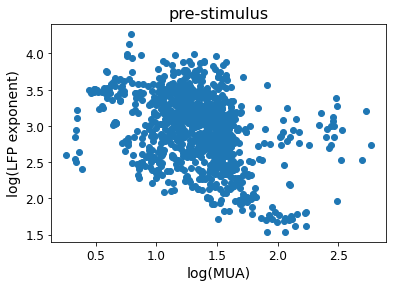

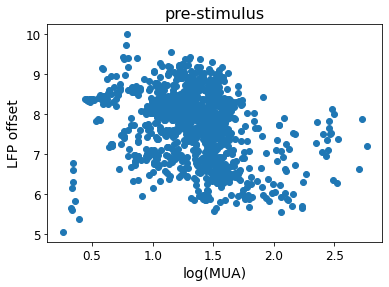

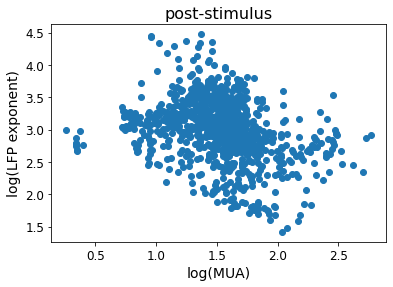

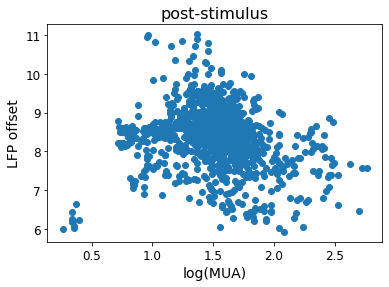

In [8]:
# # plot example MUA v aperiodic 

# df = df_merge.loc[df_merge['session']==SESSION]

# for epoch in ['pre','post']:
#     # plot example MUA v exponent
#     fig, ax = plt.subplots(1,1, figsize=[6,4])
#     ax.scatter(df[f'mua_{epoch}'], df[f'exponent_{epoch}'])
#     ax.set(xlabel="log(MUA)", ylabel="log(LFP exponent)")
#     ax.set_title(f"{epoch}-stimulus")
#     plt.show()

#     # plot example MUA v Offset
#     df = df_merge.loc[df_merge['session']==SESSION]
#     fig, ax = plt.subplots(1,1, figsize=[6,4])
#     ax.scatter(df[f'mua_{epoch}'], df[f'offset_{epoch}'])
#     ax.set(xlabel="log(MUA)", ylabel="LFP offset")
#     ax.set_title(f"{epoch}-stimulus")
#     plt.show()

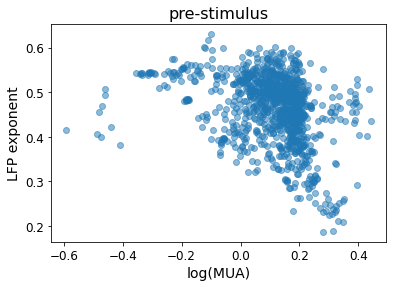

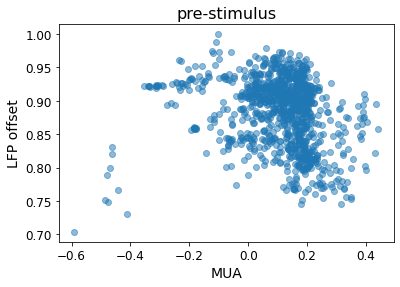

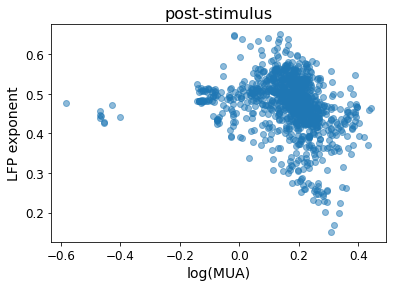

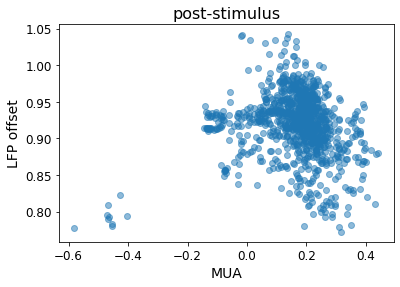

In [13]:
# # plot eample MUA v aperiodic 

# df = df_merge.loc[df_merge['session']==SESSION]

# for epoch in ['pre','post']:
#     # plot example MUA v exponent
#     fig, ax = plt.subplots(1,1, figsize=[6,4])
#     ax.scatter(np.log10(df[f'mua_{epoch}']), np.log10(df[f'exponent_{epoch}']), alpha=0.5)
#     ax.set(xlabel="log(MUA)", ylabel="LFP exponent")
#     ax.set_title(f"{epoch}-stimulus")
#     plt.show()

#     # plot example MUA v Offset
#     df = df_merge.loc[df_merge['session']==SESSION]
#     fig, ax = plt.subplots(1,1, figsize=[6,4])
#     ax.scatter(np.log10(df[f'mua_{epoch}']), np.log10(df[f'offset_{epoch}']), alpha=0.5)
#     ax.set(xlabel="MUA", ylabel="LFP offset")
#     ax.set_title(f"{epoch}-stimulus")
#     plt.show()

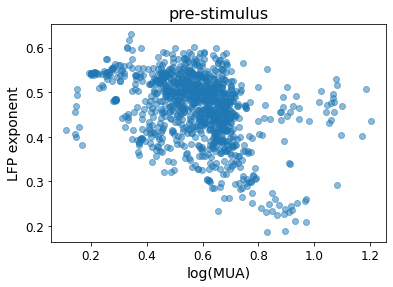

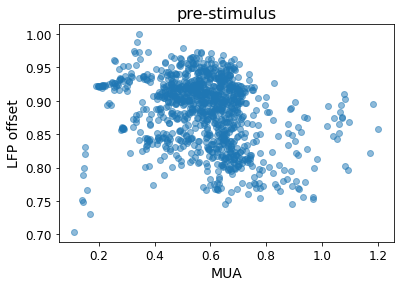

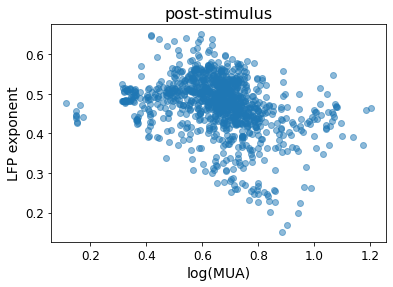

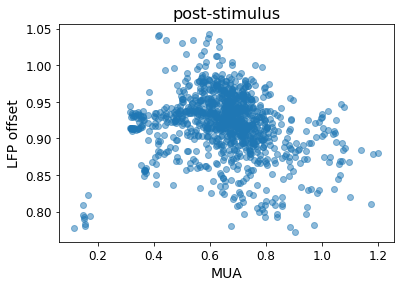

In [14]:
# # plot eample MUA v aperiodic 

# df = df_merge.loc[df_merge['session']==SESSION]

# for epoch in ['pre','post']:
#     # plot example MUA v exponent
#     fig, ax = plt.subplots(1,1, figsize=[6,4])
#     ax.scatter(np.log10(df[f'mua_raw_{epoch}']), np.log10(df[f'exponent_{epoch}']), alpha=0.5)
#     ax.set(xlabel="log(MUA)", ylabel="LFP exponent")
#     ax.set_title(f"{epoch}-stimulus")
#     plt.show()

#     # plot example MUA v Offset
#     df = df_merge.loc[df_merge['session']==SESSION]
#     fig, ax = plt.subplots(1,1, figsize=[6,4])
#     ax.scatter(np.log10(df[f'mua_raw_{epoch}']), np.log10(df[f'offset_{epoch}']), alpha=0.5)
#     ax.set(xlabel="MUA", ylabel="LFP offset")
#     ax.set_title(f"{epoch}-stimulus")
#     plt.show()

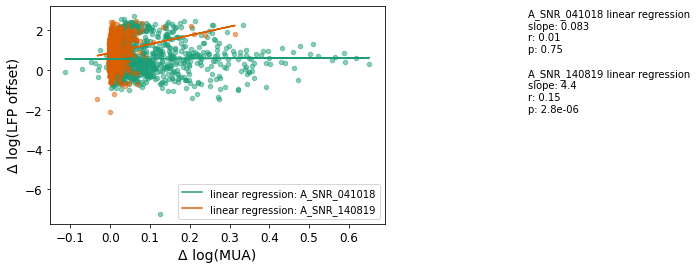

In [10]:
# temporary variable due to df_merge being 2 sessions instead of 3
colors = ["#1b9e77", "#d95f02", "#7570b3"]

# plot change in mua vs change in offset
df_merge['session'] = pd.Categorical(df_merge['session'])
fig, ax = plt.subplots(1,1, figsize=[6,4])
# df_merge.plot.scatter(x="mua_diff", y="offset_diff", c="session", cmap="viridis", alpha=0.5, ax=ax)
# df_merge.plot.scatter(x="mua_diff", y="offset_diff", c="session", cmap="viridis", alpha=0.3, ax=ax, legend=False)
# ax.set(xlabel="\u0394 log(MUA)", ylabel="\u0394 log(LFP offset)")

# add linear regression per session
for session, color, offset in zip(SESSIONS, colors, [0,3]):
    results_session = df_merge.loc[df_merge["session"]==session]

    results_session.plot.scatter(x="mua_diff", y="offset_diff", c=color, alpha=0.5, ax=ax)
    ax.set(xlabel="\u0394 log(MUA)", ylabel="\u0394 log(LFP offset)")

    (slope, intercept, rvalue, pvalue, stderr) = linregress(x=results_session["mua_diff"], y=results_session["offset_diff"])
    y_pred = intercept + slope*results_session["mua_diff"]

    label = f"{session} linear regression \nslope: {slope:.2} \nr: {rvalue:.2} \np: {pvalue:.2}"
    ax.plot(results_session["mua_diff"],y_pred, color=color, label=f"linear regression: {session}", )
    plt.text(1.05, 0.9 - offset, label)

ax.legend()
plt.show()

ax.figure.savefig(fr"{PROJECT_PATH}\figures\linregress_offset_mua.png")


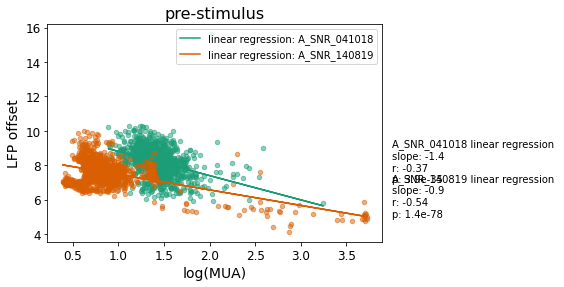

In [17]:
# plot pre stimulus mua vs offset
fig, ax = plt.subplots(1,1, figsize=[6,4])
for session, color, offset in zip(SESSIONS, colors, [0,2]):
    results_session = df_merge.loc[df_merge["session"]==session]

    results_session.plot.scatter(x="mua_pre", y="offset_pre", c=color, alpha=0.5, ax=ax)
    ax.set(xlabel="log(MUA)", ylabel="LFP offset")
    ax.set_title("pre-stimulus")

    (slope, intercept, rvalue, pvalue, stderr) = linregress(x=results_session["mua_pre"], y=results_session["offset_pre"])
    y_pred = intercept + slope*results_session["mua_pre"]

    label = f"{session} linear regression \nslope: {slope:.2} \nr: {rvalue:.2} \np: {pvalue:.2}"
    ax.plot(results_session["mua_pre"],y_pred, color=color, label=f"linear regression: {session}", )
    plt.text(4, 7 - offset, label)

ax.legend()
plt.show()

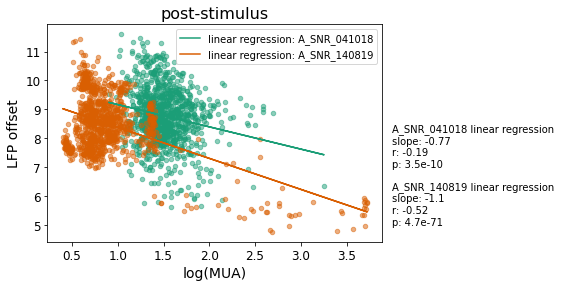

In [25]:
# plot post stimulus mua vs offset
fig, ax = plt.subplots(1,1, figsize=[6,4])
for session, color, offset in zip(SESSIONS, colors, [0,2]):
    results_session = df_merge.loc[df_merge["session"]==session]

    results_session.plot.scatter(x="mua_post", y="offset_post", c=color, alpha=0.5, ax=ax)
    ax.set(xlabel="log(MUA)", ylabel="LFP offset")
    ax.set_title("post-stimulus")

    (slope, intercept, rvalue, pvalue, stderr) = linregress(x=results_session["mua_post"], y=results_session["offset_post"])
    y_pred = intercept + slope*results_session["mua_post"]

    label = f"{session} linear regression \nslope: {slope:.2} \nr: {rvalue:.2} \np: {pvalue:.2}"
    ax.plot(results_session["mua_post"],y_pred, color=color, label=f"linear regression: {session}", )
    ax.text(4, 7 - offset, label)

ax.legend()
plt.show()

#### dev plotting func

In [55]:
def plot_regression(x_data, y_data, ax=None, title=None, xlabel=None, 
                    ylabel=None, fname_out=None, label='', label_offset=0):
    """
    Calculate and plot the linear regression for two datasets, with optional labels and file output.
    Parameters
    ----------
    x_data : 1-d array_like
        x-values of the dataset
    y_data : 1-d array_like
        y-values of the dataset
    title : str, optional
        Title of the plot
    xlabel : str, optional
        x-axis label of the plot
    ylabel : str, optional
        y-axis label of the plot
    fname_out : str, optional
        Filename of the output figure

    Returns
    -------
    None

    """

    # imports
    from scipy.stats import linregress
    
    # create figure
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
        fig.patch.set_facecolor('white') # set background color to white for text legibility
        
    # plot data
    ax.scatter(x_data, y_data, alpha=0.1)

    # run regression and plot results
    results = linregress(x_data, y_data)
    y_pred = results.slope * x_data + results.intercept
    ax.plot(x_data, y_pred, label=label, linewidth=3)

    # add regression results text
    if results.pvalue < 0.001:
        pval = f"{results.pvalue:.2e}"
    else:
        pval = f"{results.pvalue:.3f}"
    ax.text(1.05, 0.85-label_offset, 
                f"{label}\n" +
                f"    Slope: {results.slope:.3f}\n" +
                f"    Intercept: {results.intercept:.3f}\n" +
                f"    R: {results.rvalue:.3f}\n" +
                f"    p: {pval}",
                transform=ax.transAxes)

    # label figure
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
        
    # save/show figure
    if not fname_out is None:
        fig.savefig(fname_out)

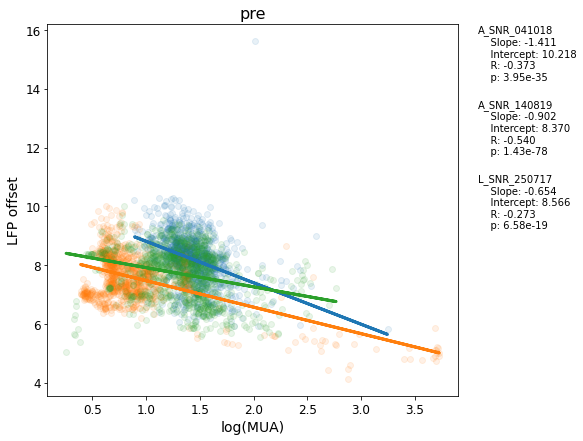

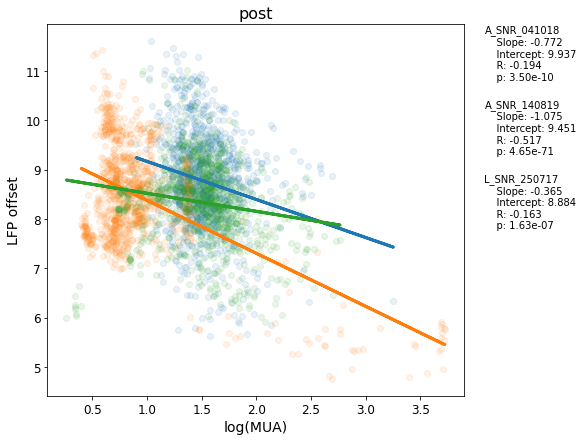

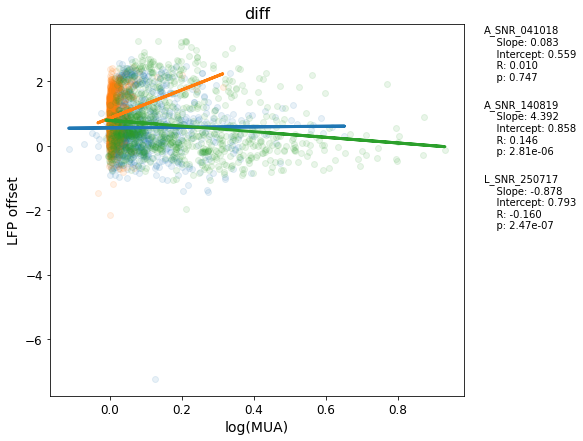

In [60]:
# plor regression: MUA vs offset

for epoch in ['pre', 'post', 'diff']:
    for i_session, session in enumerate(SESSIONS):
        x_data = df_merge.loc[df_merge['session']==session][f'mua_{epoch}']
        y_data = df_merge.loc[df_merge['session']==session][f'offset_{epoch}']

        if i_session == 0:
            plot_regression(x_data, y_data, title=epoch, xlabel='log(MUA)', ylabel='LFP offset', label=session, label_offset=0.2*i_session)
        else:    
            ax = plt.gca()
            plot_regression(x_data, y_data, ax=ax, title=epoch, xlabel='log(MUA)', ylabel='LFP offset', label=session, label_offset=0.2*i_session)

    # save
    plt.savefig(fr"{DIR_FIG}\linregress_mua_offset_{epoch}.png")

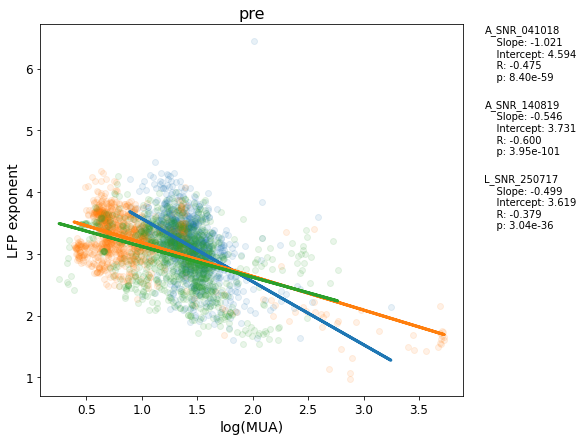

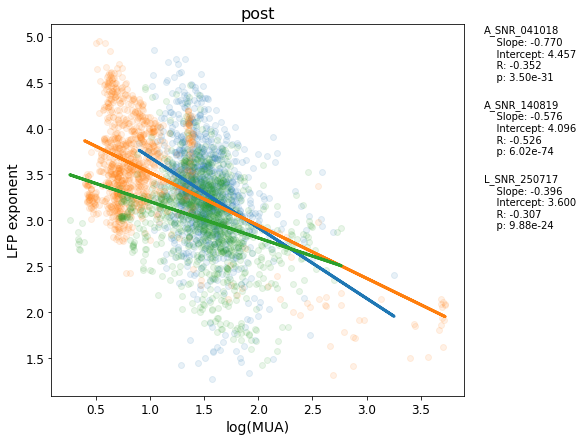

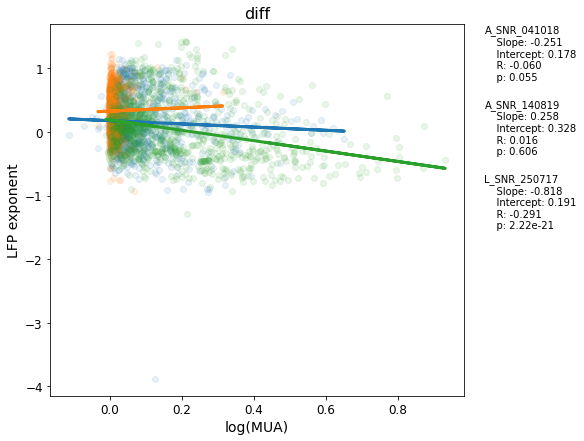

In [61]:
# plor regression: MUA vs exponent

for epoch in ['pre', 'post', 'diff']:
    for i_session, session in enumerate(SESSIONS):
        x_data = df_merge.loc[df_merge['session']==session][f'mua_{epoch}']
        y_data = df_merge.loc[df_merge['session']==session][f'exponent_{epoch}']

        if i_session == 0:
            plot_regression(x_data, y_data, title=epoch, xlabel='log(MUA)', ylabel='LFP exponent', label=session, label_offset=0.2*i_session)
        else:    
            ax = plt.gca()
            plot_regression(x_data, y_data, ax=ax, title=epoch, xlabel='log(MUA)', ylabel='LFP exponent', label=session, label_offset=0.2*i_session)

    # save
    plt.savefig(fr"{DIR_FIG}\linregress_mua_exponent_{epoch}.png")

## Plot MUA schematic

warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> in odML document section <odML>  (line 5)
Validation found 0 errors and 1 warnings in 0 Sections and 1 Properties.
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> in odML document section <odML>  (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element 

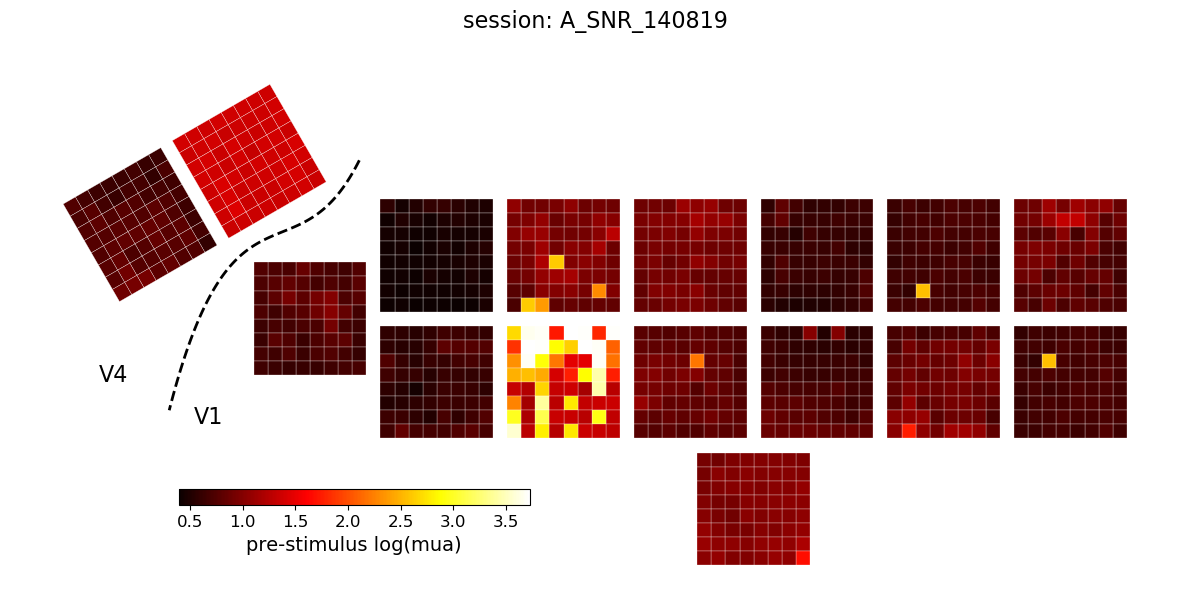

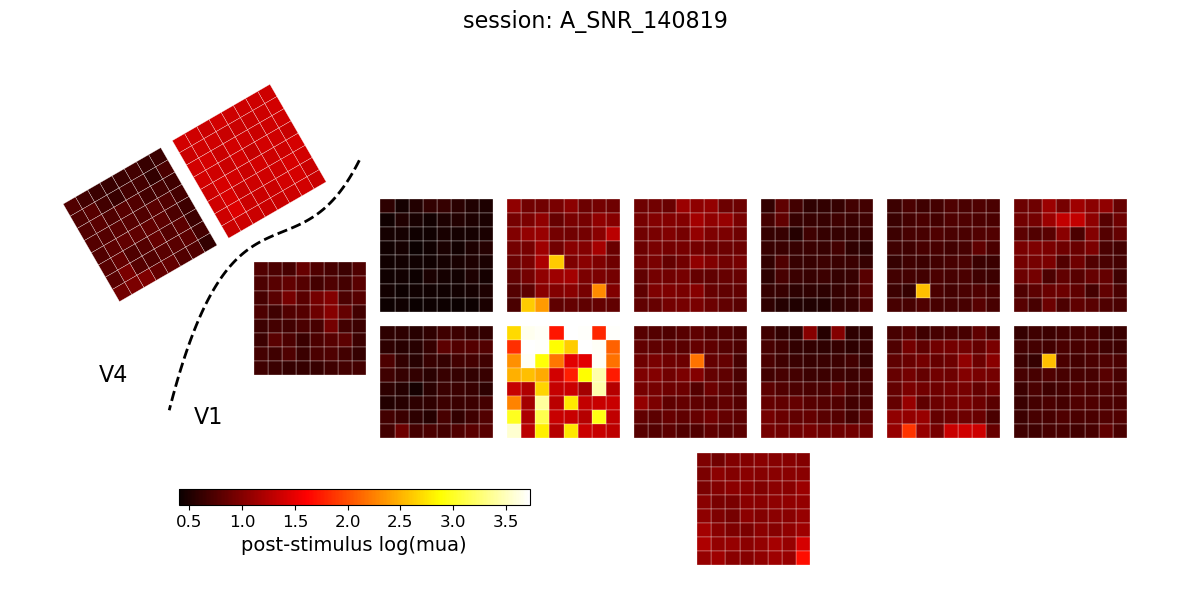

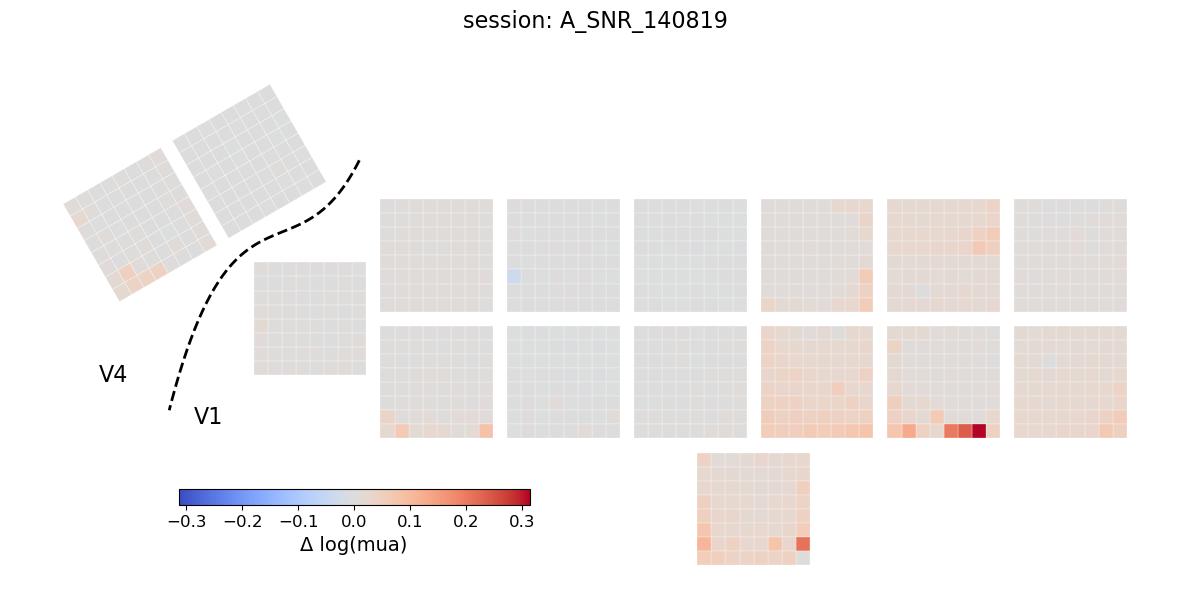

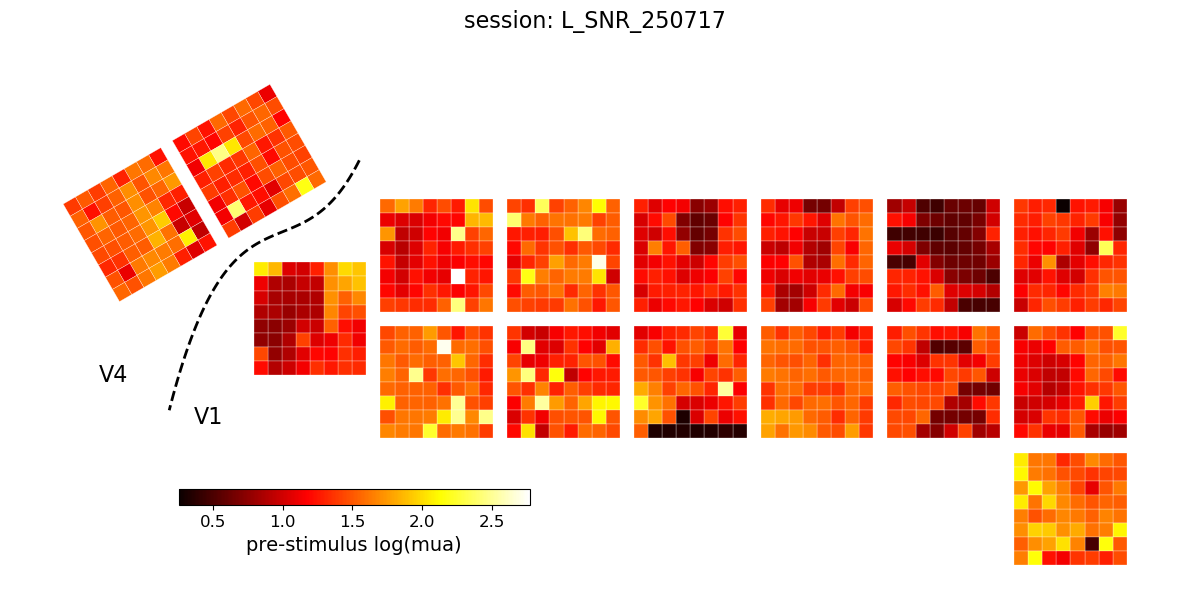

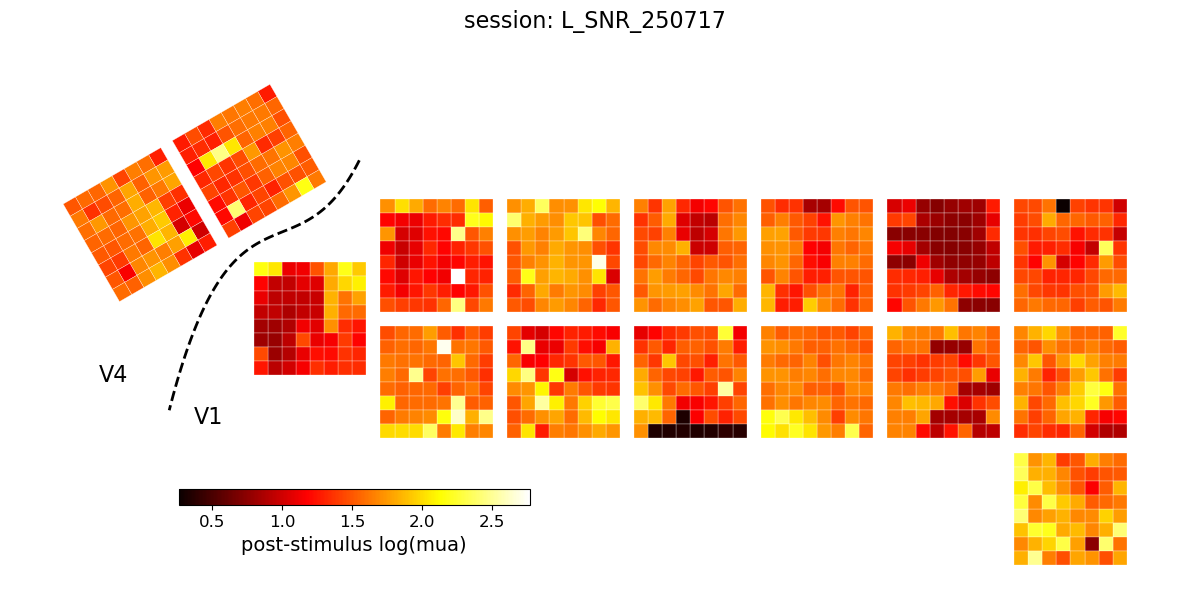

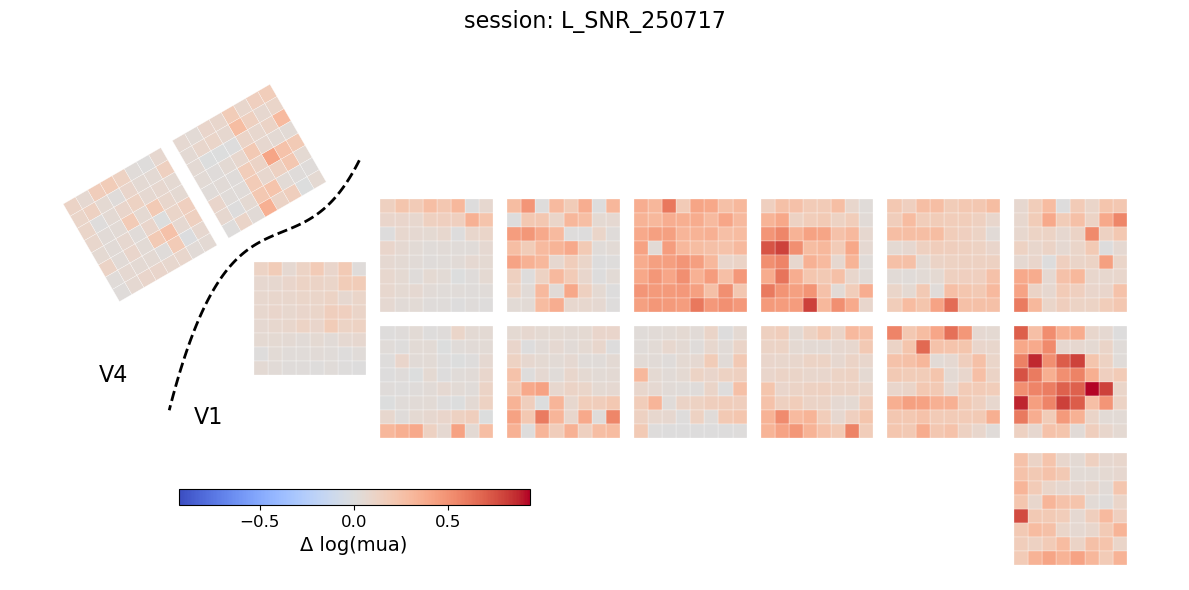

In [19]:
# plot shematic for mua pre, post and diff

for session in SESSIONS: 
    # get data for session
        df_session = df_merge[df_merge['session']==session]

        # define odml file path (contains metadata including electrode positions)
        odml_path = fr"{PROJECT_PATH}\data\dataset\{session}\metadata_{session}.odml"

        # setting limits for colorbar
        #lims = np.append(df_session[f"mua_pre"], df_session[f"mua_post"])
        #maxli = np.nanmax(lims)
        #minli = np.nanmin(lims)
        
        # pre-stimulus
        plot_schematic(df_session[f"mua_pre"], odml_path, title=f"session: {session}", 
                       label=f"pre-stimulus log(mua)", #vmin=minli, vmax=maxli, 
                       fname_out=f"{dir_out}/{session}_mua_pre.png");

        # post-stimulus
        plot_schematic(df_session[f"mua_post"], odml_path, title=f"session: {session}", 
                       label=f"post-stimulus log(mua)", #vmin=minli, vmax=maxli, 
                       fname_out=f"{dir_out}/{session}_mua_post.png");

        # change in exponent
        diff = df_session[f"mua_post"] - df_session[f"mua_pre"]
        plot_schematic(diff, odml_path, norm_type="centered", title=f"session: {session}", 
                       label=f"\u0394 log(mua)", #vmin=np.nanmin(diff), vmax=np.nanmax(diff), 
                       fname_out=f"{dir_out}/{session}_mua_diff.png");


# Plotting 04/12/2024

In [10]:
PROJECT_PATH

'G:/Shared drives/v1_v4_1024'

In [11]:
# load MUA data
mua_data = pd.read_csv(fr"{PROJECT_PATH}\data\results\mua_df.csv")

# load LFP spectral parameter results
lfp_data = pd.read_csv(fr"{PROJECT_PATH}\data\results\lfp_stm_params.csv")
mua_data

,Unnamed: 0,session,array,channel,epoch,mua
0,0,A_SNR_041018,1,0,pre,4.327240
1,1,A_SNR_041018,1,1,pre,4.336008
2,2,A_SNR_041018,1,2,pre,4.323233
3,3,A_SNR_041018,1,3,pre,4.523598
4,4,A_SNR_041018,1,4,pre,3.497945
...,...,...,...,...,...,...
6139,6139,L_SNR_250717,16,59,post,5.921929
6140,6140,L_SNR_250717,16,60,post,5.528276
6141,6141,L_SNR_250717,16,61,post,5.299164
6142,6142,L_SNR_250717,16,62,post,4.856267


In [15]:
lfp_data

,Unnamed: 0,session,channel,chan_idx,array,event,window,offset,knee,exponent,...,alpha_pw,alpha_bw,beta_cf,beta_pw,beta_bw,gamma_cf,gamma_pw,gamma_bw,error,r_squared
0,0,A_SNR_041018,0,0,1,0,0,6.795210,-1.846419,2.337249,...,NaN,NaN,20.890956,0.224983,11.992839,84.198499,0.132514,12.000000,0.032021,0.997366
1,1,A_SNR_041018,0,0,1,0,1,6.737711,-4.511377,2.295678,...,NaN,NaN,20.902825,0.226633,12.000000,61.621175,0.182840,3.827135,0.039661,0.995919
2,2,A_SNR_041018,0,0,1,0,2,6.755493,-4.149983,2.305570,...,NaN,NaN,20.926484,0.222615,12.000000,61.539609,0.193738,3.815145,0.041530,0.995477
3,3,A_SNR_041018,0,0,1,0,3,6.780586,-3.431958,2.320047,...,NaN,NaN,20.866057,0.221432,11.833854,61.507654,0.193887,3.920132,0.040069,0.995806
4,4,A_SNR_041018,0,0,1,0,4,6.825531,-1.580806,2.347456,...,NaN,NaN,20.796904,0.222093,11.686082,61.560461,0.184212,4.285739,0.035822,0.996423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535995,511995,L_SNR_250717,63,1023,16,1023,495,6.992720,-1.496442,2.293409,...,NaN,NaN,20.553714,0.316953,8.651914,62.071582,0.364958,7.753122,0.095770,0.975272
1535996,511996,L_SNR_250717,63,1023,16,1023,496,6.971888,-1.889051,2.283320,...,NaN,NaN,20.532249,0.318419,8.686486,61.977642,0.361673,7.517469,0.094312,0.975615
1535997,511997,L_SNR_250717,63,1023,16,1023,497,6.994990,-0.191089,2.298115,...,NaN,NaN,20.600150,0.298774,8.555499,62.022368,0.360953,7.569785,0.094283,0.975664
1535998,511998,L_SNR_250717,63,1023,16,1023,498,6.949316,-1.983348,2.277146,...,NaN,NaN,20.508147,0.316415,8.653674,61.919241,0.364432,7.401750,0.093088,0.976546


In [16]:
print(f"mua data lenght: {mua_data.shape[0]/3} \nlfp data length {lfp_data.shape[0]/3}")

mua data lenght: 2048.0 
lfp data length 512000.0


In [28]:
# load example MUA data
fname_in = r"D:\V1_v4_1024_electrode_resting_state_data\data\A_SNR_041018\MUAe\NSP1_array1_MUAe.nix"
segment, analog_signal = load_nix(fname_in)
signal = segment.analogsignals[0].T # transpose to get channels x time
fs = analog_signal._sampling_rate.item()

# mua_post 
mua_post_array = mua_mean[:, idx_post] # index time dimension
print(mua_post_array.shape)


NameError: name 'mua_mean' is not defined

In [27]:
signal

AnalogSignal with 157288 channels of length 64; units uV; datatype float64 
annotations: {'nix_name': 'neo.analogsignal.85ba2b95acfb4c0491f18a9f7529ecbf',
  't_stop': array(157.288) * s}
sampling rate: 1000.0 Hz
time: 0.0 s to 0.064 s

In [22]:
# epoch data into trials around stimulus times
epochs = epoch_neo_segment(segment, reset_time=True) 
epoch_times = create_times(epochs.shape[-1]/fs, fs, start_val=T_MIN) # get times for each epoch

# find indices
idx_pre = np.logical_and(epoch_times>=(0-DURATION), epoch_times<(0))
print("n sample pre:", np.sum(idx_pre))
idx_post = np.logical_and(epoch_times>=(0), epoch_times<(DURATION)) 
print("n sample post:", np.sum(idx_post))
mua_pre_array = mua_mean[:, idx_pre] # index time dimension
print(mua_pre_array.shape)

TypeError: epoch_neo_segment() missing 1 required positional argument: 'epochs'

In [24]:
from scipy.io import loadmat

In [ ]:
for session in SESSIONS:

    # loop through arrays
    for i_array in range(1, N_ARRAYS+1):
        ### print(f"    plotting array: {i_array}/{N_ARRAYS}")
        idx_nsp = (i_array+1) // 2

        # load data
        fname_in = fr"D:\V1_v4_1024_electrode_resting_state_data\data\{session}\MUAe\NSP{idx_nsp}_array{i_array}_MUAe.nix"
        lfp = np.load(f"{dir_input}/{fname_in}")

    